### Packages 

In [1]:
# system packages
import sys
import time
import warnings
import os
import fiona
from collections import Counter

# non-geo numeric packages
import numpy as np
import math
from itertools import product, combinations
import pandas as pd

# network and OSM packages
import networkx as nx
import osmnx as ox
city_geo = ox.geocoder.geocode_to_gdf

# Earth engine packages
import ee
import geemap

# General geo-packages
from rasterstats import zonal_stats
from pyproj import CRS
import libpysal
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import geopandas as gpd
import shapely
from shapely import geometry
from shapely.geometry import Point, MultiLineString, LineString, Polygon, MultiPolygon

/Users/Julian/opt/anaconda3/envs/ssml/lib/python3.10/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# latest gdf
popgridmanchester = gpd.read_file('popgridmanchester3.gpkg')

### GEE auth/initialisation, loading health outcome data, extracting population grid data

In [ ]:
# Authenticate and Initialize Google Earth Engine
#ee.Authenticate()
ee.Initialize()

In [ ]:
# Provided dataset including health outcomes
data = gpd.read_file("/Users/Julian/Desktop/Julian/PSY/Thesis/data/Greater_Manchester_NH_GIS.gpkg")

In [ ]:
# Health outcome only
data_health = data[['geometry','lsoa11cd','UNID','lsoa11nm','ID','lon','lat','Yrpotlife','Comilldis','Obes_Per_Obesprev_y15', 'Asthma_Per_Asthmaprev_y17', 'heart_Per_heartdiseaseprev_y17', 'Stroke_Per_Strokeprev_y17', 'Cancer_Per_cancerPrev_y17', 'samhi_index2019', 'prop_ibesa', 'est_qof_dep', 'antidep_rate']]


In [ ]:
# specify cities using the excel files with the cities and iso's

# Extract iso-3166 country codes
iso = pd.read_excel('/Users/Julian/Desktop/Julian/PSY/Thesis/data/iso_countries.xlsx')

# Extract cities list
cities = pd.read_excel('/Users/Julian/Desktop/Julian/PSY/Thesis/data/cities.xlsx') # all cities

# 'cities_adj' serves by default as city-input for functions
cities_adj = cities[cities['City'].isin(['Manchester'])]
cities_adj = cities_adj.reset_index()

In [ ]:
# function to extract worldpop data from GEE of the cities
def gee_worldpop_extract (city_file, iso, save_path = None):
    
    cities = city_file
    
    # Get included city areas
    OSM_incl = [cities[cities['City'] == city]['OSM_area'].tolist()[0].rsplit(', ') for city in cities['City'].tolist()]

    # Get the city geoms
    obj = [city_geo(city).dissolve()['geometry'].tolist()[0] for city in OSM_incl]
    
    # Get the city countries
    obj_displ = [city_geo(city).dissolve()['display_name'].tolist()[0].rsplit(', ')[-1]for city in OSM_incl]
    obj_displ = np.where(pd.Series(obj_displ).str.contains("Ivoire"),"CIte dIvoire",obj_displ)

    # Get the country's iso-code
    iso_list = [iso[iso['name'] == ob]['alpha3'].tolist()[0] for ob in obj_displ]

    # Based on the iso-code return the worldpop 2020
    ee_worldpop = [ee.ImageCollection("WorldPop/GP/100m/pop")\
        .filter(ee.Filter.date('2020'))\
        .filter(ee.Filter.inList('country', [io])).first() for io in iso_list]

    # Clip the countries with the city geoms.
    clipped = [ee_worldpop[i].clip(shapely.geometry.mapping(obj[i])) for i in range(0,len(obj))]

    # Create path if non-existent
    if save_path == None:
        path = ''
    else:
        path = save_path
        if not os.path.exists(path):
                    os.makedirs(path)

    # Export as TIFF file.
    # Stored in form path + USA_Los Angeles_2020.tif
    filenames = [path+iso_list[i]+'_'+cities['City'][i]+'_2020.tif' for i in range(len(obj))]
    [geemap.ee_export_image(clipped[i], filename = filenames[i]) for i in range(0,len(obj))]
    return(filenames)
    sys.stdout.flush()

In [ ]:
# Now grid based on the 27700 CRS

# function to create population grids of the cities
def city_grids_format(city_grids, cities_area, grid_size = 100):
    start_time = time.time()
    grids = []
    print(str(grid_size) + 'm resolution grids extraction')
    for i in range(len(city_grids)):
        
        # Open the raster file
        with rasterio.open(city_grids[i]) as src:
            band= src.read() # the population values
            aff = src.transform # the raster bounds and size (affine)
        
        # Get the rowwise arrays, get a 2D dataframe
        grid = pd.DataFrame()
        for b in enumerate(band[0]):
            grid = pd.concat([grid, pd.Series(b[1],name=b[0])],axis=1)
        grid= grid.unstack().reset_index()
        
        # Unstack df to columns
        grid.columns = ['row','col','value']
        grid['minx'] = aff[2]+aff[0]*grid['col']
        grid['miny'] = aff[5]+aff[4]*grid['row']
        grid['maxx'] = aff[2]+aff[0]*grid['col']+aff[0]
        grid['maxy'] = aff[5]+aff[4]*grid['row']+aff[4]
        
        # Create polygon from affine bounds and row/col indices
        grid['geometry'] = [Polygon([(grid.minx[i],grid.miny[i]),
                                   (grid.maxx[i],grid.miny[i]),
                                   (grid.maxx[i],grid.maxy[i]),
                                   (grid.minx[i],grid.maxy[i])])\
                          for i in range(len(grid))]
        
        # Set the df as geo-df
        grid = gpd.GeoDataFrame(grid, crs = 27700) 

        # Get dissolvement_key for dissolvement. 
        grid['row3'] = np.floor(grid['row']/(grid_size/100)).astype(int)
        grid['col3'] = np.floor(grid['col']/(grid_size/100)).astype(int)
        grid['dissolve_key'] = grid['row3'].astype(str) +'-'+ grid['col3'].astype(str)
        
        # Define a city's OSM area as Polygon.
        geo_ls = gpd.GeoSeries(city_geo(cities_area[i].split(', ')).dissolve().geometry)
        geo_ls = geo_ls.to_crs("EPSG:27700")
        
        # Intersect grids with the city boundary Polygon.
        insec = grid.intersection(geo_ls.tolist()[0])
        
        # Exclude grids outside the specified city boundaries
        insec = insec[insec.area > 0]
        
        # Join in other information.
        insec = gpd.GeoDataFrame(geometry = insec, crs = 27700).join(grid.loc[:, grid.columns != 'geometry'])
        
        # Dissolve into block by block grids
        popgrid = insec[['dissolve_key','geometry','row3','col3']].dissolve('dissolve_key')
        
        # Get those grids populations and area, only full blocks
        popgrid['population'] = round(insec.groupby('dissolve_key')['value'].sum()).astype(int)
        #popgrid['area_m'] = round(gpd.GeoSeries(popgrid['geometry'], crs = 27700).to_crs(3043).area).astype(int)
        popgrid = popgrid[popgrid['population'] >= 0]
        #popgrid = popgrid[popgrid['area_m'] / popgrid['area_m'].max() > 0.95]

        # Get centroids and coords
        popgrid['centroid'] = popgrid['geometry'].centroid
        #popgrid['centroid_m'] = gpd.GeoSeries(popgrid['centroid'], crs = '27700').to_crs(3043)
        popgrid['grid_lon'] = popgrid['centroid'].x
        popgrid['grid_lat'] = popgrid['centroid'].y
        popgrid = popgrid.reset_index()

        minx = popgrid.bounds['minx']
        maxx = popgrid.bounds['maxx']
        miny = popgrid.bounds['miny']
        maxy = popgrid.bounds['maxy']

        # Some geometries result in a multipolygon when dissolving (like i.e. 0.05 meters), coords error.
        # Therefore recreate the polygon.
        Poly = []
        for k in range(len(popgrid)):
            Poly.append(Polygon([(minx[k],maxy[k]),(maxx[k],maxy[k]),(maxx[k],miny[k]),(minx[k],miny[k])]))
        popgrid['geometry'] = Poly

        grids.append(popgrid)

        print(city_grids[i].rsplit('_')[3], round((time.time() - start_time)/60,2),'mns')
    return(grids)

In [ ]:
# Required preprocess for information extraction
warnings.filterwarnings('ignore')

# In essence, we use Google Earth Engine to extract a country's grid raster and clip it with the city's preferred OSM area
# Predifine in Excel: the (1) city name as "City" and (2) the OSM area that needs to be extracted as "OSM_area"
# i.e. City = "Los Angeles" and OSM_area = "Los Angeles county, Orange county CA"
files = gee_worldpop_extract(cities_adj, iso, '/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/')

# Files are downloaded automatically to the specified path. Files are also stored in Google with a downloadlink:

In [ ]:
# reprojecting the population TIF with the code snippit from the rasterio documentation

# destination CRS
dst_crs = 'EPSG:27700'

# open the source GeoTIFF file and transform the dimensions and CRS
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/GBR_Manchester_2020.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    # save the new destination GeoTIFF file with the adjusted dimensions and CRS
    with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/GBR_Manchester_2020.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
# Creation of the population grid

# clip cities from countries, format population grids
population_grids = city_grids_format(files,
                                     cities_adj['OSM_area'],
                                     grid_size = 100) # aggregating upwards to i.e. 200m, 300m etc. is possible
print(' ')

# save the dataframe
popgridmanchester = population_grids[0]

In [ ]:
# adding grid_lat/lon from 4326 for OSMNX network retrieval
popgridmanchester = popgridmanchester.to_crs("EPSG:4326")
popgridmanchester['centroid'] = popgridmanchester.geometry.centroid
popgridmanchester['grid_lon_4326'] = popgridmanchester['centroid'].x
popgridmanchester['grid_lat_4326'] = popgridmanchester['centroid'].y
popgridmanchester = popgridmanchester.to_crs("EPSG:27700")

In [ ]:
# remove centroid to be able to save it as a GPKG
popgridmanchester = popgridmanchester.drop(columns=['centroid'])

In [ ]:
# save as gkpg file
popgridmanchester.to_file("popgridmanchester3.gpkg", driver="GPKG")

In [ ]:
# open gkpg file
#popgridmanchester = gpd.read_file("popgridmanchester.gpkg")

### Create data points such as bus stops and restaurants

In [ ]:
# extract Greater Manchester polygon using OSM
manchester_osm = city_geo('Greater Manchester')

In [ ]:
# using OSM to extract data points

# specifying correct ESPG
epsg = "EPSG:27700"

# specifying the Greater Manchester polygon
manchester_poly = manchester_osm.geometry.unary_union

# extracting bus stops
bus_stops = ox.geometries_from_polygon(manchester_poly, tags={'highway': 'bus_stop'})
bus_stops = bus_stops.to_crs(epsg)
bus_stops = bus_stops[['geometry']]
bus_stops = bus_stops.reset_index()

# extracting restaurants
restaurants = ox.geometries_from_polygon(manchester_poly, tags={'amenity': ['bar', 'pub', 'restaurant', 'cafe']})
restaurants = restaurants.to_crs(epsg)
restaurants = restaurants[['geometry']]
restaurants = restaurants.reset_index()

# extracting daily shops
shops = ox.geometries_from_polygon(manchester_poly, tags={'shop': ['department_store', 'supermarket', 'convenience']})
shops.to_crs(epsg)
shops = shops[['geometry']]
shops = shops.reset_index()

# extracting cyclelanes
cycleways = ox.geometries_from_polygon(manchester_poly, tags={'cycleway': True, 'highway':'cycleway'})
cycleways.to_crs(epsg)
cycleways_c = cycleways[['geometry']]
cycleways_c = cycleways_c.reset_index()

#Create union out of all geometry extracted
temp_list = []

for index, x in cycleways_c.iterrows():
    temp_list.append(x.geometry)

series = gpd.GeoSeries(temp_list)

# convert to gdf and export as gpkg
cycleways_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(series))
#cycleways_gdf.to_file("cycleways.gpkg", driver="GPKG")

### Population sum of each grid bufferzone

In [ ]:
# create bufferzone dataframe from population grid dataframe geometries
buffer_gdf = popgridmanchester.copy()
buffer_gdf['centroid'] = buffer_gdf['geometry'].centroid
buffer_gdf['buffer'] = buffer_gdf['centroid'].buffer(500)
buffer_gdf = buffer_gdf['buffer']
buffer_gdf = gpd.GeoDataFrame(buffer_gdf, geometry='buffer')

In [ ]:
# intersect with bounds of the OSM city area so buffers don't extent beyond city borders
manpoly = city_geo('Greater Manchester').dissolve()['geometry']
manpoly = manpoly.to_crs("EPSG:27700")
bufferintersect = buffer_gdf.intersection(manpoly.geometry[0])

# I tried intersecting with a dissolved polygon from the population grid intstead of with a dissolved
# polygon from the OSM city area, because the population grid polygon contains small areas with no data
# that would then not be present within the buffers. Using rasterstats with that intersection would then 
# minimize the amount of missing data set to a negative number. This took too much time however.
# Might try again later.

# convert to gdf and save to gpkg
bufferintersect_gdf = gpd.GeoDataFrame(bufferintersect)
bufferintersect_gdf = bufferintersect_gdf.rename(columns={0: "geometry"})
bufferintersect_gdf.geometry = bufferintersect_gdf['geometry']
bufferintersect_gdf.to_file("bufferintersect_gdf.gpkg", driver="GPKG")

In [3]:
# open the buffergintersect_gdf file
bufferintersect_gdf = gpd.read_file("bufferintersect_gdf.gpkg")

In [ ]:
# get the parts from the buffer that overlap with the population grid parts with no data
start_time = time.time()

bufferintersect_gdf['savedindex'] = bufferintersect_gdf.index
difference_gdf = bufferintersect_gdf.overlay(popgridmanchester, how='difference')['savedindex']

# filter the buffer gdf of these difference parts
buffer_gdf_filtered = bufferintersect_gdf[~bufferintersect_gdf.savedindex.isin(difference_gdf.geometry)]

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [ ]:
popgridpoly = popgridmanchester['geometry']
popgridpoly = gpd.GeoDataFrame(popgridpoly)
popgridpoly = popgridpoly.dissolve()
test = popgridpoly.unary_union

In [ ]:
start_time = time.time()

# use the reprojected population TIF with CRS 27700
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/GBR_Manchester_2020.tif') as src:
    affine = src.transform
    array = src.read(1)

# get population sum statistic per bufferzone
statistics = zonal_stats(bufferintersect_gdf2, array, affine=affine, stats=['sum'], nodata=0)
    
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [ ]:
# extract the population sum per buffer from statistics
# setting values to zero if negative
population_sums = [stat['sum'] if (stat is not None and stat['sum'] >= 0) else 0 for stat in statistics]
# converting to df to add to the population grid gdf
population_sums_df = pd.DataFrame(population_sums, columns=['buffer_population'])

In [ ]:
# check amount of zero's
(population_sums_df==0).sum()

### Population density

In [ ]:
# adding population per buffer to buffer_gdf and then calculating density
bufferintersect_gdf['buffer_area'] = bufferintersect_gdf['geometry'].area

# adding both buffer population and buffer area columns to final gdf for other density calculations
popgridmanchester['buffer_population'] = population_sums_df['buffer_population']
popgridmanchester['buffer_area'] = bufferintersect_gdf['buffer_area']

# calculating population density per buffer
popgridmanchester['buffer_pop_density'] = popgridmanchester['buffer_population']/popgridmanchester['buffer_area']

In [ ]:
# save to gpkg
popgridmanchester.to_file("popgridmanchester3.gpkg", driver="GPKG")

### Calculating three-way intersections per grid centroid street network

In [ ]:
start_time = time.time()

# Download street network of Greater Manchester from osmnx and project to CRS 27700
G = ox.graph_from_place('Greater Manchester', network_type='all', simplify=True)
Gproj = ox.project_graph(G, to_crs="27700")

# Save to graphml
ox.io.save_graphml(Gproj, 'network.graphml')

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [7]:
# open graphml
Gproj = ox.load_graphml('network.graphml')

In [30]:
# sub df with lat/lon values to get their nearest nodes for truncation
popgridsub = popgridmanchester.loc[0:100, ['grid_lon', 'grid_lat', 'grid_lon_4326', 'grid_lat_4326']]
popgridsub = gpd.GeoDataFrame(popgridsub)
# center variable for the ox.graph_from_point()
popgridsub['center'] = list(zip(popgridsub.grid_lat_4326, popgridsub.grid_lon_4326))

In [74]:
# list of nearest nodes and their distances
nearest_nodes, dist = ox.distance.nearest_nodes(Gproj, popgridsub['grid_lon'],
                                                popgridsub['grid_lat'], return_dist=True)

In [75]:
# using vectorization instead of iterations through for-loops to get the nearest nodes with
# a threshold. MUCH faster.

start_time = time.time()

mask = np.vectorize(isinstance)(nearest_nodes, int)
nearest_nodes = np.where(mask, nearest_nodes, np.nan)
dist = np.where(mask, dist, np.nan)
valid_nodes = np.array([nearest_nodes, dist], np.float64)
valid_nodes = np.where(valid_nodes[1]<1000, valid_nodes[0], np.nan)
popgridsub['nearest_node'] = valid_nodes

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 0.0008599758148193359 seconds


In [ ]:
# test the map() with lambda functions for the ox.truncate.truncate_graph_dist function 
# to extract the street networks
start_time = time.time()

test = popgridsub.loc[0,'nearest_node'].map(lambda x: ox.truncate.truncate_graph_dist(Gproj, x, max_dist=1000))

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [ ]:
# test a vectorized version of the ox.truncate.truncate_graph_dist function to extract the street networks

start_time = time.time()

truncate_graph_dist_vectorized = np.vectorize(lambda x: ox.truncate.truncate_graph_dist(Gproj, x, max_dist=1000))

test = truncate_graph_dist_vectorized(popgridsub['nearest_node')

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [ ]:
# test a list comprehension to extract the street networks

start_time = time.time()

test = [ox.truncate.truncate_graph_dist(Gproj, nearest_node, max_dist=1000) for nearest_node in popgridsub['nearest_node']

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [405]:
# check how fast the ox.graph_from_point is with the map() and lambda functions
start_time = time.time()

test = popgridsub['center'].map(lambda x: ox.graph_from_point(x, dist=500, 
                                                                network_type='all'))

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 3.359591007232666 seconds


In [76]:
# truncate the street network from the nodes extracted above and limit the distance
# to a 1000 meters
start_time = time.time()

# single test
test = ox.truncate.truncate_graph_dist(Gproj, popgridsub['nearest_node'][1], max_dist=1000)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 10.934692144393921 seconds


In [ ]:
start_time = time.time()

def calculate_intersections(row):
        G = ox.graph_from_point((row['grid_lat_4326'], row['grid_lon_4326']), dist=500, network_type='drive')
        Gproj = ox.project_graph(G, to_crs="27700")
        stats = ox.stats.basic_stats(Gproj)
        return Counter(stats.values())[3]
        return 0

popgridmanchester['three-way-intersections'] = popgridmanchester.apply(lambda x: calculate_intersections, axis=1)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")


In [ ]:
# save the file to gpkg
#popgridmanchester.to_file('popgridmanchester2.gpkg', driver="GPKG")

In [210]:
# test network 
G = ox.graph_from_point((popgridsub['grid_lat_4326'][33],
                         popgridsub['grid_lon_4326'][33]),
                        dist=500,
                        network_type='all')

In [ ]:
# convert network to gdf, create polygon from it to get area
Gproj = ox.project_graph(G, to_crs="27700")
network_gdfs = ox.graph_to_gdfs(Gproj, nodes=True, edges=False)
network_poly = network_gdfs.unary_union.convex_hull
area = network_poly.area

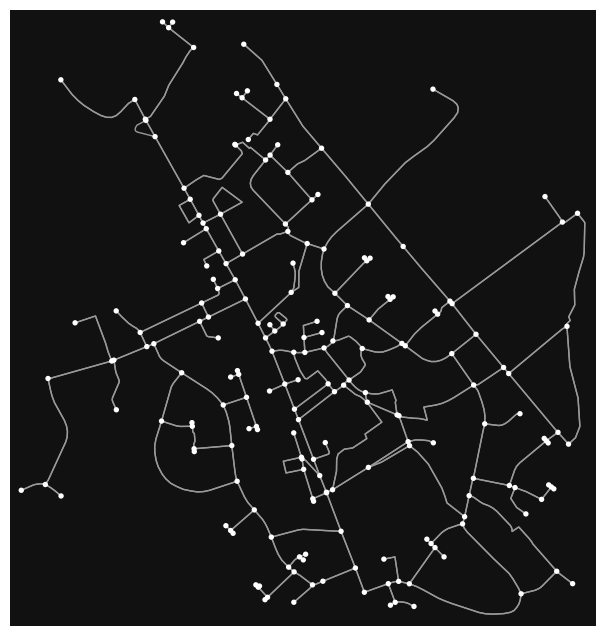

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [211]:
# plot test network graph
ox.plot_graph(G)

In [ ]:
# get stats
stats = ox.stats.basic_stats(Gproj, area=area)
stats

### Three-way-intersection density

In [ ]:
# three-way-intersections divided by the area to get the density (also in square kilometers)
popgridmanchester['three-way-intersection-density'] = popgridmanchester['three-way-intersections']/popgridmanchester['buffer_area']
popgridmanchester['three-way-intersection-density_km'] = popgridmanchester['three-way-intersections']/popgridmanchester['buffer_area_km']


In [ ]:
# save the file to gpkg
popgridmanchester.to_file('popgridmanchester2.gpkg', driver="GPKG")

### Street density

In [ ]:
# test
popgridmanchestertest = popgridmanchester[152000:152100]

start_time = time.time()

def calculate_street_density(row):
    try:
        G = ox.graph_from_point((row['grid_lat_4326'], row['grid_lon_4326']), dist=500, network_type='drive')
        stats = ox.stats.basic_stats(G, area=row['buffer_area'])
        return stats['street_density_km']
    except:
        return 0

popgridmanchestertest['street_density_km'] = popgridmanchestertest.apply(calculate_street_density, axis=1)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [ ]:
# save the file to gpkg
popgridmanchester.to_file('popgridmanchester2.gpkg', driver="GPKG")

### Calculate distance from grid centroids to nearest bus stops

In [ ]:
directory = os.getcwd() #Location where files will be saved
c = "/"

In [278]:
# sub df with lat/lon values to get their nearest nodes for truncation
popgridsub = popgridmanchester.loc[0:100000, ['geometry', 'grid_lon', 'grid_lat', 'grid_lon_4326', 'grid_lat_4326']]
popgridsub = gpd.GeoDataFrame(popgridsub, geometry='geometry')

# center variable for the ox.graph_from_point()
popgridsub['center'] = list(zip(popgridsub.grid_lat_4326, popgridsub.grid_lon_4326))

In [19]:
# get bus stops
bus_stops = ox.geometries_from_place("Greater Manchester", tags={'highway': 'bus_stop'})
bus_stops = bus_stops.to_crs("EPSG:27700")
bus_stops = bus_stops[['geometry']]
bus_stops = bus_stops.reset_index()

In [ ]:
# vectorized and adjusted version of getting the shortest distance to busstops. MUCH faster.

start_time = time.time()

# get nearest bus stops based on euclid distance, now via map() and lambda functions
polygon_index = popgridsub['geometry'].map(lambda row: bus_stops.distance(row, align=True).sort_values().index[0])
nearest_bus = bus_stops.loc[polygon_index].geometry.centroid

# list of grid centroid nearest nodes and their distances
nearest_nodes, dist = ox.distance.nearest_nodes(Gproj, popgridsub['grid_lon'],
                                                popgridsub['grid_lat'], return_dist=True)

# using vectorization instead of iterations through for-loops to get the nearest grid nodes with
# a threshold. MUCH faster.
mask = np.vectorize(isinstance)(nearest_nodes, int)
nearest_nodes = np.where(mask, nearest_nodes, np.nan)
dist = np.where(mask, dist, np.nan)
valid_nodes = np.array([nearest_nodes, dist], np.float64)
valid_nodes = np.where(valid_nodes[1]<1000, valid_nodes[0], np.nan)
popgridsub['nearest_node'] = valid_nodes

# list of bus stop nearest nodes and their distances
nearest_nodes_bus, dist_bus = ox.distance.nearest_nodes(Gproj, nearest_bus.geometry.x,
                                                nearest_bus.geometry.y, return_dist=True)

# using vectorization instead of iterations through for-loops to get the nearest bus stop nodes with
# a threshold. MUCH faster.
mask = np.vectorize(isinstance)(nearest_nodes_bus, int)
nearest_nodes = np.where(mask, nearest_nodes_bus, np.nan)
dist = np.where(mask, dist_bus, np.nan)
valid_nodes = np.array([nearest_nodes, dist], np.float64)
valid_nodes = np.where(valid_nodes[1]<1000, valid_nodes[0], np.nan)
nearest_bus_nodes = valid_nodes

# Vectorized computation of shortest path lengths with error handling
try:
    shortest_path_lengths = np.vectorize(lambda u, v: nx.shortest_path_length(Gproj, u, v, weight='length'))(popgridsub['nearest_node'], nearest_bus_nodes)
except (nx.NodeNotFound, nx.NetworkXNoPath):
    pass

popgridsub['dist_to_busstop'] = shortest_path_lengths

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [212]:
# Calculate distance variabels to POIs
start_time = time.time()

bus_dist_list = []

city = 'Greater Manchester'
espg = 'EPSG:27700'
city_path = directory + c + city

df = gpd.read_file('smaller_section2.gpkg')
df = df.to_crs(espg)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Load in street network graph
G = ox.load_graphml('network.graphml')

# Project the graph to EPSG:27700
G = ox.project_graph(G, to_crs=espg)

# Load in bus stops
busstop = gpd.read_file('bus_stops.gpkg').to_crs(espg)

# Import points as gdf and loop through them
for index, point in popgridsub.iterrows():
    polygon_index = bus_stop.distance(point.geometry).sort_values().index[0]
    nearest_bus = bus_stop.loc[polygon_index].geometry.centroid

    # Extract coordinates of point
    x, y = point.geometry.centroid.coords.xy
    x = x[0]
    y = y[0]

    # Find closest node within threshold
    nearest_nodes, dist = ox.distance.nearest_nodes(G, x, y, return_dist=True)
    if isinstance(nearest_nodes, int):
        nearest_nodes = [nearest_nodes]
        dist = [dist]
    valid_nodes = [node for node, d in zip(nearest_nodes, dist) if d <= 1000]
    if valid_nodes:
        node_counter = valid_nodes[0]
    else:
        continue

    # Extract coordinates of point
    xx, yy = nearest_bus.xy
    xx = xx[0]
    yy = yy[0]

    # Find closest node within threshold
    nearest_nodes, dist = ox.distance.nearest_nodes(G, xx, yy, return_dist=True)
    if isinstance(nearest_nodes, int):
        nearest_nodes = [nearest_nodes]
        dist = [dist]
    valid_nodes = [node for node, d in zip(nearest_nodes, dist) if d <= 1000]
    if valid_nodes:
        node_bus = valid_nodes[0]
    else:
        continue

    # Calculate shortest path within threshold
    try:
        nx.shortest_path_length(G, node_counter, node_bus, weight='length')
    except:
        s_path = 0
    else:
        s_path = nx.shortest_path_length(G, node_counter, node_bus, weight='length')

    bus_dist_list.append(s_path)

print(city + ' is done')

popgridsub['dist_to_busstop2'] = bus_dist_list

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

NameError: name 'busstop' is not defined

In [ ]:
df.to_file('popgriddistance.gpkg', driver='GPKG')

### Overlay with health outcome data

In [ ]:
# match the crs to the health data crs
popgridmanchester = popgridmanchester.to_crs("epsg:27700")

In [ ]:
# create overlay with the health outcome data
overlay = data_health.overlay(popgridmanchester, how='intersection')

In [ ]:
# save overlay
overlay.to_file("overlay.gpkg", driver="GPKG")